In [1]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);

In [2]:
IM_ID = '6120_2_2'
POLY_TYPE = '1'  # buildings

In [3]:
# Load grid size
PATH = '/Volumes/Mini/Dstl_Satellite_Imagery_Feature_Detection'
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open(str(PATH)+'/grid_sizes.csv')):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        break

In [4]:
x_max, y_min

(0.009188, -0.00904)

In [5]:
# Load train poly with shapely
train_polygons = None
for _im_id, _poly_type, _poly in csv.reader(open(str(PATH)+'/train_wkt_v4.csv')):
    if _im_id == IM_ID and _poly_type == POLY_TYPE:
        train_polygons = shapely.wkt.loads(_poly)
        break

In [8]:
# Read image with tiff
im_rgb = tiff.imread(str(PATH)+'/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

In [41]:
def get_scalers():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

x_scaler, y_scaler = get_scalers()

train_polygons_scaled = shapely.affinity.scale(
    train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

In [51]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask = mask_for_polygons(train_polygons_scaled)

In [58]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

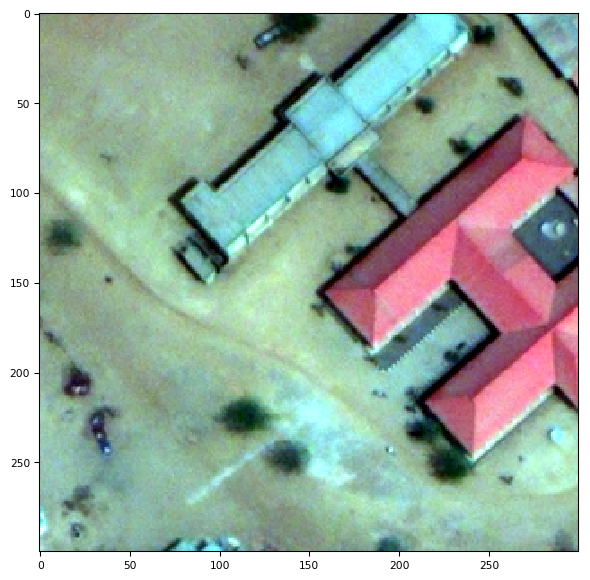

In [67]:
import matplotlib.pyplot as plt
tiff.imshow(255 * scale_percentile(im_rgb[2900:3200,2000:2300]))
plt.show()